# Finetuning von Finbert für Kommentare 

## Import

In [104]:
import os
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import DebertaV2Tokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, EarlyStoppingCallback
import evaluate
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score,classification_report, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import transformers
import warnings
import random
import nltk
from nltk.corpus import wordnet

In [105]:
# Cuda pruefen
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [106]:
DATA_PATH = '../../data/processed/'

In [107]:
# Trainingsdaten laden
df_all_posts = pd.read_csv(os.path.join(DATA_PATH, "training_data_posts.csv"))

# Testdaten laden
df_test_posts = pd.read_csv(os.path.join(DATA_PATH, "test_data_posts.csv"))

# Nur relevante Spalten + Bereinigung
df_all_posts = df_all_posts[["text", "label"]].dropna()
df_all_posts["label"] = df_all_posts["label"].astype(int)

df_test_posts = df_test_posts[["text", "label"]].dropna()
df_test_posts["label"] = df_test_posts["label"].astype(int)


Data Augmenataion

In [108]:
nltk.download("wordnet")

def synonym_replace(text, n=1):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if not synonyms:
            continue
        synonym_words = [lemma.name().replace("_", " ") for s in synonyms for lemma in s.lemmas()]
        synonym_words = [word for word in synonym_words if word != random_word]
        if synonym_words:
            new_words = [synonym_words[0] if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return " ".join(new_words)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...


## Train- Test-split

In [109]:
# 80/20 Split für Training und Validierung
train_df, val_df = train_test_split(
    df_all_posts,
    test_size=0.2,
    stratify=df_all_posts["label"],
    random_state=42
)

# Bearish-Subset kopieren & augmentieren
augmented_bearish = train_df[train_df['label'] == 0].copy()
augmented_bearish['text'] = augmented_bearish['text'].apply(lambda x: synonym_replace(x, n=2))

# Kombinieren & durchmischen
train_df_augmented = pd.concat([train_df, augmented_bearish], ignore_index=True).sample(frac=1, random_state=42)

# Optional: neue Labelverteilung anzeigen
#print(train_df_augmented['label'].value_counts())

# Indizes zurücksetzen
train_df = train_df_augmented.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = df_test_posts.copy()
df_test_posts = df_test_posts.reset_index(drop=True)

print("✅ Daten erfolgreich vorbereitet:")
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


✅ Daten erfolgreich vorbereitet:
Train: 379 | Val: 74 | Test: 298


In [110]:
print(f"Train size: {len(train_df)}")
print(f"Val size: {len(val_df)}")
print(f"Test size: {len(test_df)}")
print("Train labels:\n", train_df["label"].value_counts())


Train size: 379
Val size: 74
Test size: 298
Train labels:
 label
0    174
1    156
2     49
Name: count, dtype: int64


## Weighted Loss

Zur Einbindung einer gewichteten oder spezialisierten Loss-Funktion wird compute_loss überschrieben.

In [111]:
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, loss_fn=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn  # Speichert die benutzerdefinierte Verlustfunktion

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")  # Extrahiert die Labels aus den Eingaben
        outputs = model(**inputs)  # Führt eine Vorwärtsausbreitung durch
        logits = outputs.logits  # Extrahiert die Logits aus den Ausgaben
        loss = self.loss_fn(logits, labels)  # Berechnet den Verlust mit der benutzerdefinierten Funktion
        return (loss, outputs) if return_outputs else loss  # Gibt den Verlust (und optional die Ausgaben) zurück

In [112]:
# Manuelle Class Weights – hier z. B. stärkerer Fokus auf neutral
weights_tensor = torch.tensor([2.0, 1.0, 2.0], dtype=torch.float)

loss_fn = torch.nn.CrossEntropyLoss(weight=weights_tensor.to(device))


## Model

Pfade für das Finetuning-Experiment setzen und Ordner sicherstellen

In [113]:
EXPERIMENTS_BASE_PATH = "../../models/experiments/"  # Basisverzeichnis für alle Experiment-Modelle

MODEL_PATHS = {
    "finbert_posts": os.path.join(EXPERIMENTS_BASE_PATH, "finbert_posts"),  # Zielordner für FinBERT auf Post-Daten
}

for path in MODEL_PATHS.values():
    os.makedirs(path, exist_ok=True)  # Ordner anlegen, falls noch nicht vorhanden


Modell & Tokenizer laden

In [114]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATHS["finbert_posts"])  # FinBERT-Tokenizer laden
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATHS["finbert_posts"], num_labels=3)  # Modell mit 3 Klassen


Tokenizer-Funktion

In [115]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length= 512)  # Standard-Tokenisierung


Tokenisierung + Formatierung der Datensätze

In [116]:
train_ds = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)  # Training
val_ds = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)      # Validierung
test_ds = Dataset.from_pandas(df_test_posts).map(tokenize_function, batched=True)  # Testset: manuell gelabelte Posts

train_ds = train_ds.rename_column("label", "labels")
val_ds = val_ds.rename_column("label", "labels")
test_ds = test_ds.rename_column("label", "labels")

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/379 [00:00<?, ? examples/s]

Map: 100%|██████████| 298/298 [00:00<00:00, 3097.91 examples/s]


Metrikfunktion für Evaluation

In [117]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)  # Index des höchsten Scores → vorhergesagte Klasse
    return {
        "accuracy": accuracy_score(labels, preds),         # Genauigkeit
        "f1": f1_score(labels, preds, average="macro")      # F1-Score über alle Klassen (gleich gewichtet)
    }


Grid-Search: Finetuning von FinBERT (Posts) mit verschiedenen Lernraten
Wir testen mehrere Lernraten, loggen die Trainingsdauer, speichern die besten Modelle und extrahieren die F1-Lernkurve zur späteren Analyse.

In [118]:
results = {}  # Dictionary zum Speichern der Ergebnisse für jede Lernrate
lrs = [2e-5, 1e-5, 5e-6, 3e-6, 1e-6]  # Liste der Lernraten, die getestet werden sollen

for lr in lrs:
    print(f"Starte Training für learning_rate = {lr}")  # Fortschrittsanzeige

    # Modell für jede Lernrate neu laden (sonst Verfälschung!)
    model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone", num_labels=3)

    output_dir = os.path.join(MODEL_PATHS["finbert_posts"], f"finetuned_lr_{lr}")
    logging_dir = os.path.join("../../logs/finbert_posts", f"lr_{lr}")
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(logging_dir, exist_ok=True)

    # Trainingskonfiguration für HuggingFace Trainer
    training_args = TrainingArguments(
        output_dir=output_dir,                      # Wohin das Modell gespeichert wird
        evaluation_strategy="epoch",                # Evaluation nach jeder Epoche
        save_strategy="epoch",                      # Modell speichern nach jeder Epoche
        learning_rate=lr,                           # Aktuelle Lernrate aus der Schleife
        per_device_train_batch_size=8,              # Batch-Größe für Training
        per_device_eval_batch_size=8,               # Batch-Größe für Evaluation
        num_train_epochs=10,                        # Max. Anzahl der Epochen
        weight_decay=0.01,                          # Gewichtung für L2-Regularisierung
        load_best_model_at_end=True,                # Bestes Modell basierend auf F1 automatisch laden
        metric_for_best_model="f1",                 # F1 als Auswahlkriterium für das beste Modell
        logging_dir=logging_dir,                    # Speicherort für TensorBoard/Logs
        logging_strategy="epoch",                   # Logging-Strategie: nach jeder Epoche
        report_to="none",                           # Keine externe Logging-Plattform (z. B. wandb)
        remove_unused_columns=False,                # Wichtig bei Custom Loss: alle Features behalten
        disable_tqdm=True                           # Kein Fortschrittsbalken
    )

    # Trainer mit Custom Loss (z. B. gewichteter CrossEntropy oder Focal Loss)
    trainer = WeightedLossTrainer(
        model=model,                                # FinBERT-Modell
        args=training_args,                         # Trainingsargumente
        train_dataset=train_ds,                     # Trainingsdaten
        eval_dataset=val_ds,                        # Validierungsdaten
        tokenizer=tokenizer,                        # Tokenizer für Preprocessing
        compute_metrics=compute_metrics,            # Funktion zur Berechnung von Accuracy & F1
        loss_fn=loss_fn,                            # Loss-Funktion mit class weights
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Frühzeitiger Abbruch
    )

    # Trainingszeit messen
    start = time.time()
    trainer.train()
    end = time.time()

    # Lernkurve extrahieren: nur eval_f1-Werte
    logs = trainer.state.log_history
    epoch_logs = [log for log in logs if "eval_f1" in log]
    df = pd.DataFrame(epoch_logs)[["epoch", "eval_f1"]]
    df["learning_rate"] = lr  # Lernrate zur Kurve hinzufügen

    # Ergebnisse in Dictionary speichern
    results[lr] = {
        "f1_curve": df,                         # F1-Verlauf pro Epoche
        "best_f1": df["eval_f1"].max(),         # Bester F1-Wert
        "trainer": trainer                      # Referenz auf den Trainer
    }

    print(f"Training für learning_rate = {lr} abgeschlossen in {end - start:.2f} Sekunden.")


Starte Training für learning_rate = 2e-05


c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_12508\3254372665.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 1.2874, 'grad_norm': 13.23775863647461, 'learning_rate': 1.8e-05, 'epoch': 1.0}
{'eval_loss': 1.0287208557128906, 'eval_accuracy': 0.6216216216216216, 'eval_f1': 0.6339597603575123, 'eval_runtime': 1.4359, 'eval_samples_per_second': 51.535, 'eval_steps_per_second': 6.964, 'epoch': 1.0}
{'loss': 0.5773, 'grad_norm': 32.17930221557617, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.0}
{'eval_loss': 1.578208327293396, 'eval_accuracy': 0.6351351351351351, 'eval_f1': 0.6227690438216754, 'eval_runtime': 1.4783, 'eval_samples_per_second': 50.059, 'eval_steps_per_second': 6.765, 'epoch': 2.0}
{'loss': 0.3861, 'grad_norm': 20.81422233581543, 'learning_rate': 1.4e-05, 'epoch': 3.0}
{'eval_loss': 1.6075634956359863, 'eval_accuracy': 0.6081081081081081, 'eval_f1': 0.6124263038548753, 'eval_runtime': 1.5152, 'eval_samples_per_second': 48.838, 'eval_steps_per_second': 6.6, 'epoch': 3.0}
{'train_runtime': 78.438, 'train_samples_per_second': 48.318, 'train_steps_per_second': 6.119, 'trai

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_12508\3254372665.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 1.5378, 'grad_norm': 17.375215530395508, 'learning_rate': 9e-06, 'epoch': 1.0}
{'eval_loss': 1.1052727699279785, 'eval_accuracy': 0.581081081081081, 'eval_f1': 0.5657767607424358, 'eval_runtime': 1.5943, 'eval_samples_per_second': 46.415, 'eval_steps_per_second': 6.272, 'epoch': 1.0}
{'loss': 0.6173, 'grad_norm': 33.090396881103516, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.0}
{'eval_loss': 1.1074949502944946, 'eval_accuracy': 0.6351351351351351, 'eval_f1': 0.6289950664950665, 'eval_runtime': 1.722, 'eval_samples_per_second': 42.974, 'eval_steps_per_second': 5.807, 'epoch': 2.0}
{'loss': 0.4066, 'grad_norm': 17.68447494506836, 'learning_rate': 7e-06, 'epoch': 3.0}
{'eval_loss': 1.2757580280303955, 'eval_accuracy': 0.581081081081081, 'eval_f1': 0.5826475279106859, 'eval_runtime': 2.0245, 'eval_samples_per_second': 36.552, 'eval_steps_per_second': 4.939, 'epoch': 3.0}
{'loss': 0.3124, 'grad_norm': 3.02618145942688, 'learning_rate': 6e-06, 'epoch': 4.0}
{'eval_loss': 1.5

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_12508\3254372665.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 2.1623, 'grad_norm': 23.914432525634766, 'learning_rate': 4.5e-06, 'epoch': 1.0}
{'eval_loss': 1.1359572410583496, 'eval_accuracy': 0.47297297297297297, 'eval_f1': 0.48817204301075273, 'eval_runtime': 1.7638, 'eval_samples_per_second': 41.955, 'eval_steps_per_second': 5.67, 'epoch': 1.0}
{'loss': 0.771, 'grad_norm': 33.83106231689453, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.0}
{'eval_loss': 0.9915810823440552, 'eval_accuracy': 0.5945945945945946, 'eval_f1': 0.5838110838110838, 'eval_runtime': 1.7312, 'eval_samples_per_second': 42.746, 'eval_steps_per_second': 5.776, 'epoch': 2.0}
{'loss': 0.5454, 'grad_norm': 16.014097213745117, 'learning_rate': 3.5e-06, 'epoch': 3.0}
{'eval_loss': 1.048376202583313, 'eval_accuracy': 0.6081081081081081, 'eval_f1': 0.5865766110190731, 'eval_runtime': 1.739, 'eval_samples_per_second': 42.553, 'eval_steps_per_second': 5.75, 'epoch': 3.0}
{'loss': 0.4609, 'grad_norm': 35.89689254760742, 'learning_rate': 3e-06, 'epoch': 4.0}
{'eval_loss'

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_12508\3254372665.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 2.652, 'grad_norm': 14.646346092224121, 'learning_rate': 2.7e-06, 'epoch': 1.0}
{'eval_loss': 1.3890893459320068, 'eval_accuracy': 0.4864864864864865, 'eval_f1': 0.5067460317460317, 'eval_runtime': 1.7682, 'eval_samples_per_second': 41.852, 'eval_steps_per_second': 5.656, 'epoch': 1.0}
{'loss': 1.0611, 'grad_norm': 43.433109283447266, 'learning_rate': 2.4000000000000003e-06, 'epoch': 2.0}
{'eval_loss': 1.0510098934173584, 'eval_accuracy': 0.5540540540540541, 'eval_f1': 0.569754338517016, 'eval_runtime': 1.7271, 'eval_samples_per_second': 42.847, 'eval_steps_per_second': 5.79, 'epoch': 2.0}
{'loss': 0.7338, 'grad_norm': 15.714781761169434, 'learning_rate': 2.1e-06, 'epoch': 3.0}
{'eval_loss': 1.0304524898529053, 'eval_accuracy': 0.5945945945945946, 'eval_f1': 0.598902550207476, 'eval_runtime': 1.7564, 'eval_samples_per_second': 42.13, 'eval_steps_per_second': 5.693, 'epoch': 3.0}
{'loss': 0.6137, 'grad_norm': 46.39310073852539, 'learning_rate': 1.8e-06, 'epoch': 4.0}
{'eval_los

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_12508\3254372665.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 3.775, 'grad_norm': 9.658581733703613, 'learning_rate': 9e-07, 'epoch': 1.0}
{'eval_loss': 2.5718963146209717, 'eval_accuracy': 0.3783783783783784, 'eval_f1': 0.40805031446540885, 'eval_runtime': 2.3549, 'eval_samples_per_second': 31.423, 'eval_steps_per_second': 4.246, 'epoch': 1.0}
{'loss': 2.3011, 'grad_norm': 80.08452606201172, 'learning_rate': 8e-07, 'epoch': 2.0}
{'eval_loss': 1.8340623378753662, 'eval_accuracy': 0.44594594594594594, 'eval_f1': 0.45886627034168015, 'eval_runtime': 2.3656, 'eval_samples_per_second': 31.281, 'eval_steps_per_second': 4.227, 'epoch': 2.0}
{'loss': 1.7017, 'grad_norm': 21.623605728149414, 'learning_rate': 7e-07, 'epoch': 3.0}
{'eval_loss': 1.4861735105514526, 'eval_accuracy': 0.4864864864864865, 'eval_f1': 0.5155785638960789, 'eval_runtime': 2.4082, 'eval_samples_per_second': 30.728, 'eval_steps_per_second': 4.152, 'epoch': 3.0}
{'loss': 1.3655, 'grad_norm': 71.45350646972656, 'learning_rate': 6e-07, 'epoch': 4.0}
{'eval_loss': 1.307578682899

## Evaluation

### Plot

C:\Users\hp\AppData\Local\Temp\ipykernel_12508\239583412.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


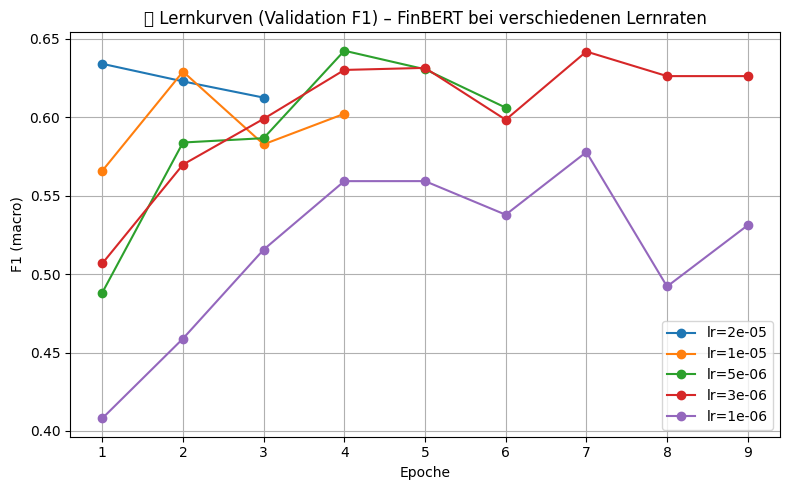

In [119]:
plt.figure(figsize=(8, 5))

for lr, data in results.items():
    df = data["f1_curve"]
    plt.plot(df["epoch"], df["eval_f1"], marker="o", label=f"lr={lr}")

plt.title("📈 Lernkurven (Validation F1) – FinBERT bei verschiedenen Lernraten")
plt.xlabel("Epoche")
plt.ylabel("F1 (macro)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [120]:
for lr, res in results.items():
    print(f"lr={lr}: best_f1={res['best_f1']:.4f}")


lr=2e-05: best_f1=0.6340
lr=1e-05: best_f1=0.6290
lr=5e-06: best_f1=0.6423
lr=3e-06: best_f1=0.6418
lr=1e-06: best_f1=0.5777


In [121]:
# Beste Lernrate bestimmen
best_lr = max(results.items(), key=lambda x: x[1]["best_f1"])[0]
best_trainer = results[best_lr]["trainer"]

print(f"\n🏆 Beste Lernrate: {best_lr} mit F1 = {results[best_lr]['best_f1']:.4f}")



🏆 Beste Lernrate: 5e-06 mit F1 = 0.6423


### Evaluation des besten Modells auf dem separaten Testset

In [ ]:
# Vorhersage auf dem Testset
test_results = best_trainer.predict(test_ds)

# Klassen aus den Logits extrahieren
y_pred = test_results.predictions.argmax(axis=1)  # höchste Wahrscheinlichkeit = Vorhersageklasse
y_true = test_results.label_ids                   # echte Labels

# Hauptmetriken berechnen
f1_macro = f1_score(y_true, y_pred, average="macro")           # Durchschnitt über alle Klassen
kappa = cohen_kappa_score(y_true, y_pred)                      # Interrater Agreement

# Ergebnisse ausgeben
print("\nEvaluation auf Testset:")
print("F1-Score (macro):", round(f1_macro, 4))
print("Cohen’s Kappa:   ", round(kappa, 4))
print("\nKlassifikationsreport:")
print(classification_report(y_true, y_pred))


Evaluation auf Testset:
F1-Score (macro): 0.5329
Cohen’s Kappa:    0.2895

Klassifikationsreport:
              precision    recall  f1-score   support

           0       0.47      0.66      0.55        95
           1       0.71      0.55      0.62       162
           2       0.45      0.41      0.43        41

    accuracy                           0.57       298
   macro avg       0.54      0.54      0.53       298
weighted avg       0.60      0.57      0.57       298



Alle falsch bewerteten Texte

In [123]:
wrong = [(i, p, t) for i, (p, t) in enumerate(zip(y_pred, y_true)) if p != t]
wrong_df = test_df.iloc[[i for i, _, _ in wrong]].copy()
wrong_df["predicted"] = [p for _, p, _ in wrong]
wrong_df["true"] = [t for _, _, t in wrong]

wrong_df[["text", "true", "predicted"]].head(10)


,text,true,predicted
0,What’s wrong with cutting losses and buying ba...,2,1
1,Ethereum (ETH) White Paper,1,0
5,Gas Fee Challenges across different blockchain...,1,0
9,Scam on Binance Hey guys I just wanna warn you...,1,2
10,Ethereum's Funeral,2,0
11,It’s ugly out there today. Here’s a PSA to ev...,2,0
12,what's wrong using a decentralized application...,1,0
13,"Grow a bag first, then invest Not sure what to...",1,0
14,Is Matt Hougan right or wrong about the latest...,1,0
21,Days like this make you glad you didn’t paper ...,0,2
